In [1]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from itertools import cycle
from reproject import reproject_interp
import imageio.v3 as iio


import warnings
warnings.filterwarnings('ignore')   

plt.style.use('paper.mplstyle')

In [2]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

def get_croppeddata(hdu, ra, dec, width, height):
    """
    Function to crop data from an HDU object based on the provided region properties.

    Parameters:
        hdu (astropy.io.fits.ImageHDU): The input HDU object.
        i (int): Index of the region in the regions dictionary.
        regions (dict): Dictionary containing region properties.

    Returns:
        astropy.io.fits.ImageHDU: The cropped HDU object.
    """
    
    hdu_crop = hdu.copy()  # Copy the HDU object to avoid modifying the original data
    wcs = WCS(hdu_crop)  # Create a WCS object from the HDU header

    centre = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')  # Create a SkyCoord object for the center of the region
    cutout = Cutout2D(hdu_crop.data, centre, [width*u.deg*1.2, height*u.deg*1.2], wcs=wcs)  # Create a rectangular cutout
    hdu_crop = fits.PrimaryHDU(cutout.data, cutout.wcs.to_header())
    
    del hdu 
    del cutout  # Delete the cutout to free up memory

    return hdu_crop  # Return the cropped HDU object

# Deinfe colours
cmap1 = plt.cm.binary(np.linspace(0., 1, 64))
cmap2 = colorcet.cm.fire(np.linspace(0, 1, 128))
cmaplist = np.vstack((cmap1, cmap2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmaplist)
cmap.set_under(cmap(0))
cmap.set_bad(color=cmap(0))

In [3]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

file_mus = '%s/data_hstha/ngc1566/muse/NGC1566-0.80asec_MAPS.fits' %root_dir 
file_hst = '%s/data_hstha/ngc1566/hst_contsub/ngc1566_hst_ha_sic.fits' %root_dir 
file_hstcat = '%s/data_hstha_nebulae_catalogue/ngc1566/catalogue/ngc1566_mask.fits' %root_dir 
file_hstcpx = '%s/data_hstha_nebulae_catalogue/ngc1566/catalogue/ngc1566_complexity.fits' %root_dir 
file_muscat = '%s/data_hstha/ngc1566/muse/NGC1566_nebmask.fits' %root_dir 

# Roated the JWST image to match the orientation of the MUSE and HST images
# sips -r 5.5 --padColor FFFFFF STScI-01HNGA39FNN541ZAF484AMYSDR.png -o jwst_hst_rotated.png
# sips -r 5.5 --padColor FFFFFF STScI-01HMA01C49P3TD74277KABGZSG.png -o jwst_rotated.png
# sips -r 5.5 --padColor FFFFFF STScI-01HM9ZT72EHPYSDHWW5D9N8J9Y.png -o hst_rotated.png

file_jwst = '%s/data_hstha/ngc1566/jwst/ngc1566_nircam_lv3_f300m_i2d_anchor.fits' %root_dir 
file_jwst_png = '%s/data_hstha/ngc1566/rgb/jwst_rotated.png' %root_dir
file_hst_png = '%s/data_hstha/ngc1566/rgb/hst_rotated.png' %root_dir

hdu_mus = fits.open(file_mus)['HA6562_FLUX']
hdu_hst = fits.open(file_hst)[0]
hdu_hstcat = fits.open(file_hstcat)[0]
hdu_muscat = fits.open(file_muscat)[0]
hdu_hstcpx = fits.open(file_hstcpx)[0]

hdu_jwst = fits.open(file_jwst)[1]

hdu_hstcat_masked = fits.open(file_hstcat)[0]
hdu_muscat_masked = fits.open(file_muscat)[0]

hdu_hstcat_masked.data = np.array(hdu_hstcat_masked.data, dtype=float)
hdu_muscat_masked.data = np.array(hdu_muscat_masked.data, dtype=float)

hdu_hstcat_masked.data[hdu_hstcat_masked.data==-1] = np.nan
hdu_muscat_masked.data[hdu_muscat_masked.data==-1] = np.nan

In [4]:
data_png = iio.imread(file_jwst_png)
data_png = data_png[:,:,2]
data_png = data_png[::-1]

data_jwst = hdu_jwst.data.copy()
hdr_jwst = hdu_jwst.header.copy()

print('Shape jwst %i %i' %data_jwst.shape)
print('Shape png %i %i' %data_png.shape)

print('CRVALS %f %f' %(hdr_jwst['CRVAL1'], hdr_jwst['CRVAL2']))
print('CRPIX %f %f' %(hdr_jwst['CRPIX1'], hdr_jwst['CRPIX2']))

crpix1 = (data_png.shape[1]/2)-31
crpix2 = (data_png.shape[0]/2)-195

hdr_jwst['CRPIX1'] = crpix1
hdr_jwst['CRPIX2'] = crpix2

hdu_hwst_new = fits.PrimaryHDU(data=data_png, header=hdr_jwst)
hdu_hwst_new.writeto('%s/data_hstha/ngc1566/jwst/tmp.fits' %root_dir, overwrite=True)

Shape jwst 4244 2531
Shape png 3648 2447
CRVALS 65.001647 -54.940314
CRPIX 1269.260011 2114.477800


In [5]:
# # centres_x = [64.9808488, 65.0204538, 64.9797801, 65.0015901, 65.0183791]
# # centres_y = [-54.9379159, -54.9505656, -54.9331407, -54.9378791, -54.9347992]
# # widths = heights = [0.0017257, 0.0016319, 0.00047222, 0.00082778, 0.00082778]

# centres_x = [64.9808488]
# centres_y = [-54.9379159]
# widths = heights = [0.0017257]

# hdu_mus_crop = []
# hdu_hst_crop = []
# hdu_muscat_crop = []
# hdu_hstcat_crop = []
# hdu_hstcpx_crop = []

# for i, (centre_x, centre_y, width, height) in enumerate(zip(centres_x, centres_y, widths, heights)):

#     hdu_mus_crop += [get_croppeddata(hdu_mus, centre_x, centre_y, width*2, height*2)]
#     hdu_hst_crop += [get_croppeddata(hdu_hst, centre_x, centre_y, width*2, height*2)]
#     hdu_muscat_crop += [get_croppeddata(hdu_muscat, centre_x, centre_y, width*2, height*2)]
#     hdu_hstcat_crop += [get_croppeddata(hdu_hstcat, centre_x, centre_y, width*2, height*2)]
#     hdu_hstcpx_crop += [get_croppeddata(hdu_hstcpx, centre_x, centre_y, width*2, height*2)]
#     # hdu_muscat_crop[i] = fits.PrimaryHDU(reproject_interp(hdu_muscat_crop[i], hdu_hstcat_crop[i].header)[0], hdu_hstcat_crop[i].header)


In [6]:
# fig = plt.figure(figsize=(8.7, 10)) 
# n = 5

# centres = zip(centres_x, centres_y, widths, heights)
# for i, (centre_x, centre_y, width, height) in enumerate(centres):

#     j = i+1
#     ax1 = aplpy.FITSFigure(hdu_mus_crop[i], figure=fig, subplot=(6,n,j))
#     ax2 = aplpy.FITSFigure(hdu_hst_crop[i], figure=fig, subplot=(6,n,j+n))
#     ax3 = aplpy.FITSFigure(hdu_muscat_crop[i], figure=fig, subplot=(6,n,j+(2*n)))
#     ax4 = aplpy.FITSFigure(hdu_hstcat_crop[i], figure=fig, subplot=(6,n,j+(3*n)))
#     ax5 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(6,n,j+(4*n)))
#     ax6 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(6,n,j+(5*n)))

#     vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.99])
#     vmin2, vmax2 = np.nanpercentile(hdu_hst.data, [10, 99.95])
#     vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
#     vmin4, vmax4 = np.nanpercentile(hdu_muscat.data, [0,100])
    
#     ax1.show_colorscale(cmap=cmap, stretch='log', vmin=vmin1, vmax=vmax1)
#     ax2.show_colorscale(cmap=cmap, stretch='sqrt', vmin=vmin2, vmax=vmax2)
#     ax3.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin3, vmax=vmax3)
#     ax4.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin4, vmax=vmax4)
#     ax5.show_rgb(file_hst_png)
#     ax6.show_rgb(file_jwst_png)

#     ax1.show_contour(hdu_muscat_crop[i], levels=[0], colors='black', linewidths=1)
#     ax2.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
#     ax3.show_contour(hdu_muscat_crop[i], levels=[0], colors='black', linewidths=1)
#     ax4.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
#     ax5.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
#     ax6.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)

#     for ax in [ax1, ax2, ax3, ax4, ax5, ax6]: 

#         ax.recenter(centre_x, centre_y, width=width*2, height=height*2)

#         ax.axis_labels.hide()
#         ax.tick_labels.hide()
#         ax.axis_labels.hide()
#         ax.tick_labels.hide()

#         ax.set_nan_color('lightgrey')
#         ax.ticks.set_color('black')

#         ax.add_scalebar(100/(17.7e6/206265)*u.arcsec, corner='bottom right')
#         ax.scalebar.set_label('100pc')

#     if i == 0:
#         ax1.add_label(0.035, 0.95, 'MUSE', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
#         ax2.add_label(0.035, 0.95, 'HST', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
#         ax3.add_label(0.035, 0.95, 'MUSE cat.', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
#         ax4.add_label(0.035, 0.95, 'HST cat.', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
#         ax5.add_label(0.035, 0.95, 'HST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
#         ax6.add_label(0.035, 0.95, 'JWST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')


# for i, ax in enumerate(fig.get_axes()):

#     axes = fig.get_axes()
#     ra_ = axes[i].coords[0]
#     dec_ = axes[i].coords[1]
#     dec_.ticklabels.set_rotation(90)
#     axes[i].grid(True, alpha=0.35, ls=':', color='white')
#     axes[i].set_facecolor('lightgrey')

# fig.tight_layout(h_pad=0, w_pad=0)
# fig.subplots_adjust(wspace=0.05, hspace=0.05)

# plt.savefig('./figs/maps_hstmuse_ngc1566_zoom.pdf', dpi=250, bbox_inches='tight', transparent=True)

In [7]:
from regions import Regions, RectangleSkyRegion, CircleSkyRegion, EllipseSkyRegion

def get_regions(regions_file):
    """
    Extracts region properties from a regions file and converts coordinates to image coordinates.

    Args:
        regions_file (str): Path to the regions file.

    Returns:
        dict: Dictionary containing region properties.

    """
    print(f'[INFO] [get_regions] Opening regions file (this may take a min)... ')
    # regions = pyregion.open(regions_file).as_imagecoord(header)
    regions = Regions.read(regions_file)
    n = len(regions)

    # Initialize empty arrays for storing region properties
    ra = np.empty(n) * np.nan * u.deg
    dec = np.empty(n) * np.nan * u.deg
    radius = np.empty(n) * np.nan * u.deg

    print(f'[INFO] [get_regions] Getting info for {n} regions...')

    for i, region in enumerate(regions):
        # Extract the region properties and store them in the respective arrays
        ra[i] = float(region.center.ra.deg) * u.deg
        dec[i] = float(region.center.dec.deg) * u.deg
        radius[i] = region.radius

    # Create a SkyCoord object for the positions
    position = SkyCoord(ra=ra, dec=dec, frame='icrs')

    # Return a dictionary containing the region properties
    return ra.value, dec.value, radius.value, radius.value, n

[INFO] [get_regions] Opening regions file (this may take a min)... 
[INFO] [get_regions] Getting info for 5 regions...


In [13]:
regions_file = './regs/nebs_complex.reg'
centres_x, centres_y, widths, heights, n = get_regions(regions_file)

hdu_mus_crop = []
hdu_hst_crop = []
hdu_muscat_crop = []
hdu_hstcat_crop = []
hdu_hstcpx_crop = []

for i, (centre_x, centre_y, width, height) in enumerate(zip(centres_x, centres_y, widths, heights)):

    hdu_mus_crop += [get_croppeddata(hdu_mus, centre_x, centre_y, width*2, height*2)]
    hdu_hst_crop += [get_croppeddata(hdu_hst, centre_x, centre_y, width*2, height*2)]
    hdu_muscat_crop += [get_croppeddata(hdu_muscat, centre_x, centre_y, width*2, height*2)]
    hdu_hstcat_crop += [get_croppeddata(hdu_hstcat, centre_x, centre_y, width*2, height*2)]
    hdu_hstcpx_crop += [get_croppeddata(hdu_hstcpx, centre_x, centre_y, width*2, height*2)]
    # hdu_muscat_crop[i] = fits.PrimaryHDU(reproject_interp(hdu_muscat_crop[i], hdu_hstcat_crop[i].header)[0], hdu_hstcat_crop[i].header)

[INFO] [get_regions] Opening regions file (this may take a min)... 
[INFO] [get_regions] Getting info for 5 regions...


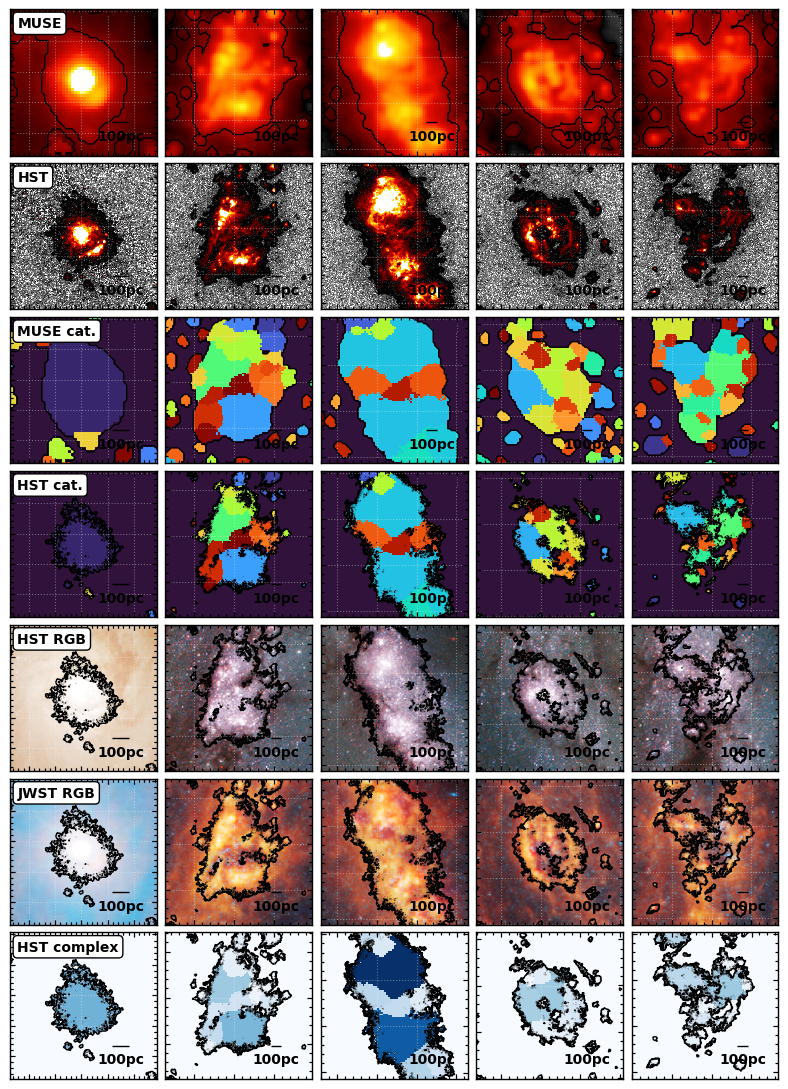

In [14]:
fig = plt.figure(figsize=(8, 11)) 

centres = zip(centres_x, centres_y, widths, heights)
for i, (centre_x, centre_y, width, height) in enumerate(centres):

    j = i+1
    ax1 = aplpy.FITSFigure(hdu_mus_crop[i], figure=fig, subplot=(7,n,j))
    ax2 = aplpy.FITSFigure(hdu_hst_crop[i], figure=fig, subplot=(7,n,j+n))
    ax3 = aplpy.FITSFigure(hdu_muscat_crop[i], figure=fig, subplot=(7,n,j+(2*n)))
    ax4 = aplpy.FITSFigure(hdu_hstcat_crop[i], figure=fig, subplot=(7,n,j+(3*n)))
    ax5 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(7,n,j+(4*n)))
    ax6 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(7,n,j+(5*n)))
    ax7 = aplpy.FITSFigure(hdu_hstcpx_crop[i], figure=fig, subplot=(7,n,j+(6*n)))

    vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.99])
    vmin2, vmax2 = np.nanpercentile(hdu_hst.data, [10, 99.95])
    vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin4, vmax4 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin7, vmax7 = np.nanpercentile(hdu_hstcpx.data, [0,100])
    
    ax1.show_colorscale(cmap=cmap, stretch='log', vmin=vmin1, vmax=vmax1)
    ax2.show_colorscale(cmap=cmap, stretch='sqrt', vmin=vmin2, vmax=vmax2)
    ax3.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin3, vmax=vmax3)
    ax4.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin4, vmax=vmax4)
    ax5.show_rgb(file_hst_png)
    ax6.show_rgb(file_jwst_png)
    ax7.show_colorscale(cmap='Blues', stretch='linear', vmin=vmin7, vmax=vmax7)

    ax1.show_contour(hdu_muscat_crop[i], levels=[0], colors='black', linewidths=1)
    ax2.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax3.show_contour(hdu_muscat_crop[i], levels=[0], colors='black', linewidths=1)
    ax4.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax5.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax6.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax7.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]: 

        ax.recenter(centre_x, centre_y, width=width*2, height=height*2)

        ax.axis_labels.hide()
        ax.tick_labels.hide()
        ax.axis_labels.hide()
        ax.tick_labels.hide()

        ax.set_nan_color('lightgrey')
        ax.ticks.set_color('black')

        ax.add_scalebar(100/(17.7e6/206265)*u.arcsec, corner='bottom right')
        ax.scalebar.set_label('100pc')

    if i == 0:
        ax1.add_label(0.05, 0.95, 'MUSE', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax2.add_label(0.05, 0.95, 'HST', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax3.add_label(0.05, 0.95, 'MUSE cat.', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax4.add_label(0.05, 0.95, 'HST cat.', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax5.add_label(0.05, 0.95, 'HST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax6.add_label(0.05, 0.95, 'JWST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax7.add_label(0.05, 0.95, 'HST complex', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')

for i, ax in enumerate(fig.get_axes()):

    axes = fig.get_axes()
    ra_ = axes[i].coords[0]
    dec_ = axes[i].coords[1]
    dec_.ticklabels.set_rotation(90)
    axes[i].grid(True, alpha=0.35, ls=':', color='white')
    axes[i].set_facecolor('lightgrey')

fig.tight_layout(h_pad=0, w_pad=0)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('./figs/maps_hstmuse_ngc1566_zoom_complex.pdf', dpi=250, bbox_inches='tight', transparent=True)

In [15]:
regions_file = './regs/nebs_simple.reg'
centres_x, centres_y, widths, heights, n = get_regions(regions_file)

hdu_mus_crop = []
hdu_hst_crop = []
hdu_muscat_crop = []
hdu_hstcat_crop = []
hdu_hstcpx_crop = []

for i, (centre_x, centre_y, width, height) in enumerate(zip(centres_x, centres_y, widths, heights)):

    hdu_mus_crop += [get_croppeddata(hdu_mus, centre_x, centre_y, width*2, height*2)]
    hdu_hst_crop += [get_croppeddata(hdu_hst, centre_x, centre_y, width*2, height*2)]
    hdu_muscat_crop += [get_croppeddata(hdu_muscat, centre_x, centre_y, width*2, height*2)]
    hdu_hstcat_crop += [get_croppeddata(hdu_hstcat, centre_x, centre_y, width*2, height*2)]
    hdu_hstcpx_crop += [get_croppeddata(hdu_hstcpx, centre_x, centre_y, width*2, height*2)]
    # hdu_muscat_crop[i] = fits.PrimaryHDU(reproject_interp(hdu_muscat_crop[i], hdu_hstcat_crop[i].header)[0], hdu_hstcat_crop[i].header)

[INFO] [get_regions] Opening regions file (this may take a min)... 
[INFO] [get_regions] Getting info for 5 regions...


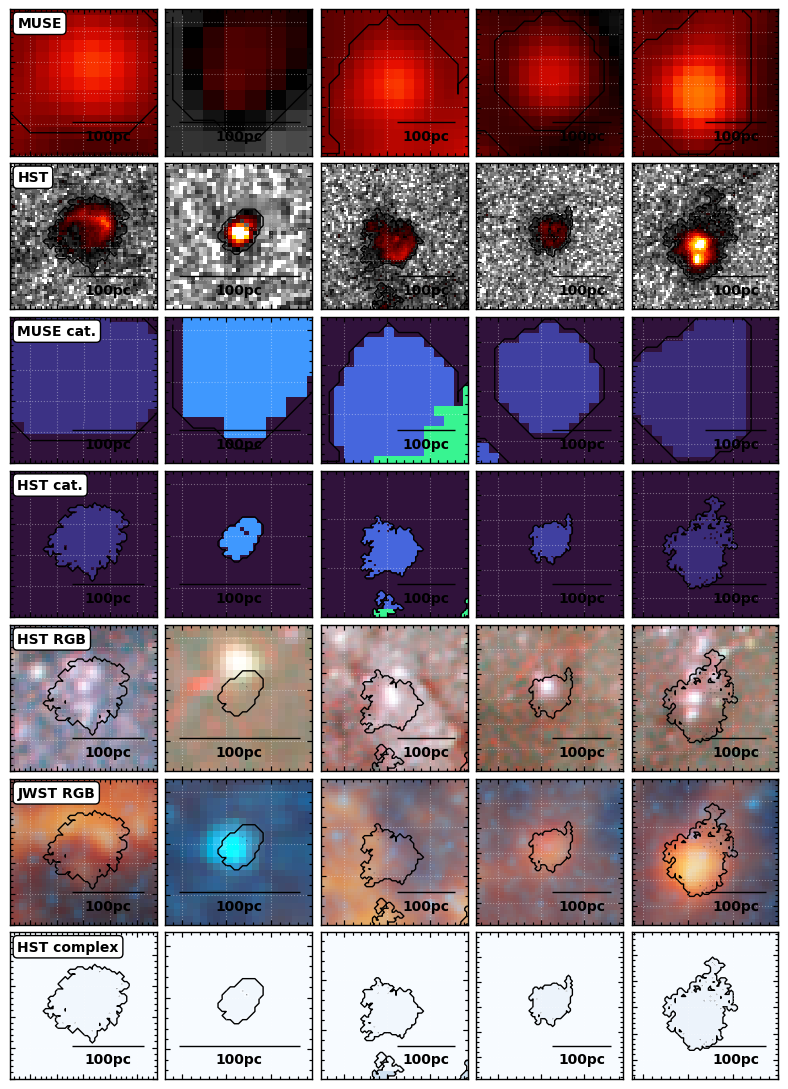

In [16]:
fig = plt.figure(figsize=(8, 11)) 

centres = zip(centres_x, centres_y, widths, heights)
for i, (centre_x, centre_y, width, height) in enumerate(centres):

    j = i+1
    ax1 = aplpy.FITSFigure(hdu_mus_crop[i], figure=fig, subplot=(7,n,j))
    ax2 = aplpy.FITSFigure(hdu_hst_crop[i], figure=fig, subplot=(7,n,j+n))
    ax3 = aplpy.FITSFigure(hdu_muscat_crop[i], figure=fig, subplot=(7,n,j+(2*n)))
    ax4 = aplpy.FITSFigure(hdu_hstcat_crop[i], figure=fig, subplot=(7,n,j+(3*n)))
    ax5 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(7,n,j+(4*n)))
    ax6 = aplpy.FITSFigure(hdu_hwst_new, figure=fig, subplot=(7,n,j+(5*n)))
    ax7 = aplpy.FITSFigure(hdu_hstcpx_crop[i], figure=fig, subplot=(7,n,j+(6*n)))

    vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.99])
    vmin2, vmax2 = np.nanpercentile(hdu_hst.data, [10, 99.95])
    vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin4, vmax4 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin7, vmax7 = np.nanpercentile(hdu_hstcpx.data, [0,100])
    
    ax1.show_colorscale(cmap=cmap, stretch='log', vmin=vmin1, vmax=vmax1)
    ax2.show_colorscale(cmap=cmap, stretch='sqrt', vmin=vmin2, vmax=vmax2)
    ax3.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin3, vmax=vmax3)
    ax4.show_colorscale(cmap='turbo', stretch='linear', vmin=vmin4, vmax=vmax4)
    ax5.show_rgb(file_hst_png)
    ax6.show_rgb(file_jwst_png)
    ax7.show_colorscale(cmap='Blues', stretch='linear', vmin=vmin7, vmax=vmax7)

    ax1.show_contour(hdu_muscat_crop[i], levels=[0], colors='black', linewidths=1)
    ax2.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax3.show_contour(hdu_muscat_crop[i], levels=[0], colors='black', linewidths=1)
    ax4.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax5.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax6.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)
    ax7.show_contour(hdu_hstcat_crop[i], levels=[0], colors='black', linewidths=1)

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]: 

        ax.recenter(centre_x, centre_y, width=width*2, height=height*2)

        ax.axis_labels.hide()
        ax.tick_labels.hide()
        ax.axis_labels.hide()
        ax.tick_labels.hide()

        ax.set_nan_color('lightgrey')
        ax.ticks.set_color('black')

        ax.add_scalebar(100/(17.7e6/206265)*u.arcsec, corner='bottom right')
        ax.scalebar.set_label('100pc')

    if i == 0:
        ax1.add_label(0.05, 0.95, 'MUSE', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax2.add_label(0.05, 0.95, 'HST', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax3.add_label(0.05, 0.95, 'MUSE cat.', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax4.add_label(0.05, 0.95, 'HST cat.', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax5.add_label(0.05, 0.95, 'HST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax6.add_label(0.05, 0.95, 'JWST RGB', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax7.add_label(0.05, 0.95, 'HST complex', relative=True, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')

for i, ax in enumerate(fig.get_axes()):

    axes = fig.get_axes()
    ra_ = axes[i].coords[0]
    dec_ = axes[i].coords[1]
    dec_.ticklabels.set_rotation(90)
    axes[i].grid(True, alpha=0.35, ls=':', color='white')
    axes[i].set_facecolor('lightgrey')

fig.tight_layout(h_pad=0, w_pad=0)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('./figs/maps_hstmuse_ngc1566_zoom_simple.pdf', dpi=250, bbox_inches='tight', transparent=True)